In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.utils import plot_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

/Users/matthew/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


## Define the image preprocessing methods

In [ ]:
def preprocess(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     pd = 0.4 * r + 0.4 * g + 0.2 * b
#     pd = pd * (1. / 255) - 0.5
    pd=rgb * (1. / 255) #- 0.5
    return pd

def prepareDataArrays(iterator):
    X = np.empty((0, 14400))
    y = np.empty((0,1))
    X_buffer = np.empty((0, 14400))
    y_buffer = np.empty((0,1))
    
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])
        
        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = preprocess(image)
        image = image.reshape((14400))

        X_buffer = np.append(X_buffer, [image], axis=0)
        y_buffer = np.append(y_buffer, label)
        
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')
        if recordCounter % 1000 == 0:
            print("Merging")
            X = np.append(X, [X_buffer])
            y = np.append(y, [y_buffer])
            X_buffer = np.empty((0, 14400))
            y_buffer = np.empty((0,1))
    
    print("Done")        
    X = np.append(X, [X_buffer])
    y = np.append(y, y_buffer)
    
    X = X.reshape((recordCounter, 14400))
    y = y.reshape((recordCounter,))
    y = np.round(y / 6)
    y = y + 7
    return X, y

# Load the datasets for training 

## (from tfrecord to RAM)

In [ ]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")

print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)

## (from RAM to NPZ file)

In [ ]:
np.savez("arrays_01color.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val)

## (from NPZ file to RAM)

In [2]:
npRecall = np.load("arrays_01color.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]

## One-hot Encode

In [3]:
# (xt, yt), (xv, yv) = mnist.load_data()
X_train = X_train.astype('float32')
y_train = y_train.astype('uint8')
X_val = X_val.astype('float32')
y_val = y_val.astype('uint8')
y_train = keras.utils.to_categorical(y_train, 15)
y_val = keras.utils.to_categorical(y_val, 15)

## Define and compile the neural network

In [5]:
# model = Sequential()
# model.add(Dense(2048, kernel_initializer="uniform", activation="relu", input_dim=14400))
# model.add(Dense(1024, kernel_initializer="uniform", activation="relu"))
# model.add(Dense(512, kernel_initializer="uniform", activation="relu"))
# model.add(Dense(15))
# model.add(Activation("softmax"))

inputs = Input(shape=(14400,), name='pixels')
x = Dense(2048, activation='relu', name='relu1')(inputs)
x = Dense(1024, activation='relu', name='relu2')(x)
x = Dense(512, activation='relu', name='relu3')(x)
predictions = Dense(15, activation='softmax', name='onehot')(x)

In [6]:
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])

In [8]:
model.fit(X_train, y_train,
          batch_size=116,
          epochs=6,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 30000 samples, validate on 5000 samples
Epoch 1/6
30000/30000 [==============================] - 175s 6ms/step - loss: 1.2262 - acc: 0.5408 - val_loss: 1.1405 - val_acc: 0.5722
Epoch 2/6
30000/30000 [==============================] - 170s 6ms/step - loss: 1.1695 - acc: 0.5563 - val_loss: 1.1176 - val_acc: 0.5612
Epoch 3/6
30000/30000 [==============================] - 170s 6ms/step - loss: 1.1291 - acc: 0.5683 - val_loss: 1.1370 - val_acc: 0.5628
Epoch 4/6
30000/30000 [==============================] - 173s 6ms/step - loss: 1.1109 - acc: 0.5783 - val_loss: 1.1377 - val_acc: 0.5724
Epoch 5/6
30000/30000 [==============================] - 174s 6ms/step - loss: 1.0944 - acc: 0.5793 - val_loss: 1.0623 - val_acc: 0.5860
Epoch 6/6
30000/30000 [==============================] - 171s 6ms/step - loss: 1.0746 - acc: 0.5857 - val_loss: 1.0848 - val_acc: 0.5846


In [9]:
model.save_weights('./weights.h5')
model.to_json()

'{"backend": "tensorflow", "class_name": "Model", "config": {"layers": [{"inbound_nodes": [], "class_name": "InputLayer", "config": {"batch_input_shape": [null, 14400], "dtype": "float32", "sparse": false, "name": "pixels"}, "name": "pixels"}, {"inbound_nodes": [[["pixels", 0, 0, {}]]], "class_name": "Dense", "config": {"kernel_regularizer": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"seed": null, "mode": "fan_avg", "scale": 1.0, "distribution": "uniform"}}, "activation": "relu", "bias_initializer": {"class_name": "Zeros", "config": {}}, "bias_constraint": null, "trainable": true, "kernel_constraint": null, "units": 2048, "bias_regularizer": null, "activity_regularizer": null, "use_bias": true, "name": "relu1"}, "name": "relu1"}, {"inbound_nodes": [[["relu1", 0, 0, {}]]], "class_name": "Dense", "config": {"kernel_regularizer": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"seed": null, "mode": "fan_avg", "scale": 1.0, "distributi

In [2]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
saver = tf.train.Saver()
with K.get_session() as sess:
    K.set_learning_phase(0)
    saver.save(sess, './tfmodel/model')

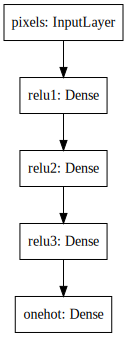

In [11]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))